# Consolidated Machine Failure Analysis

## Libraries

In [3]:
# 3rd party
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
try:
    import dtreeviz
    %config InlineBackend.figure_format = 'retina' # Make visualizations look good
except:
    print('Please run "conda uninstall python-graphviz; conda uninstall graphviz; pip install dtreeviz" to install the tree visualization library')   
%matplotlib inline

# standard library
import time

# internal imports
from exploratory_analysis import util  # make_difference_features, make_multiplicative_features, calculate_and_display_accuracy

# constants
RANDOM_SEED = 42
TEST_SIZE = 0.2

## Preparing the data

### Preprocessing

In [4]:
data = pd.read_csv("machine failure.csv")

# combine failure types into one overall failure column
data['Machine failure'] = np.where((data['TWF'] == 1) | (data['HDF'] == 1) | (data['PWF'] == 1) | (data['OSF'] == 1), 1, 0)
# drop unneeded columns
data.drop(['UDI','Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)

# add interaction features
subtraction_columns = util.make_difference_features(data.drop(columns=['Machine failure', 'Type']))
multiplication_columns = util.make_multiplicative_features(data.drop(columns=['Machine failure', 'Type']))
data = pd.concat([data, subtraction_columns, multiplication_columns], axis=1)

# perform different methods of transforming the quality
mapped_data = data.copy()
dummied_data = data.copy()

#### Mapping the quality type without one-hot encoding

In [5]:
# directly map the quality type without one-hot encoding
quality_map = {'L': 1, 'M': 2, 'H': 3}
mapped_data['Type'] = mapped_data['Type'].map(quality_map)

#### One-hot encoding the quality type

In [6]:
# one-hot encode the quality type
dummied_data = pd.get_dummies(dummied_data, columns=['Type',])

### Splitting

In [7]:
# split the mapped data
X_map = mapped_data.drop(columns='Machine failure')
y_map = mapped_data['Machine failure']
X_map_train, X_map_test, y_map_train, y_map_test = train_test_split(X_map, y_map, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_map)

# split the one-hot encoded data
X_dummy = dummied_data.drop(columns='Machine failure')
y_dummy = dummied_data['Machine failure']
X_dummy_train, X_dummy_test, y_dummy_train, y_dummy_test = train_test_split(X_dummy, y_dummy, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y_dummy)


### Standardizing

In [8]:
# standardize the mapped data
scaler = StandardScaler()
columns_to_scale = list(X_map_train.columns)
columns_to_scale.remove('Type')                # type is not numerical and more categorical

X_map_train[columns_to_scale] = scaler.fit_transform(X_map_train[columns_to_scale])
X_map_test[columns_to_scale] = scaler.transform(X_map_test[columns_to_scale])

# standardize the dummied data
X_dummy_train = scaler.fit_transform(X_dummy_train)
X_dummy_test = scaler.transform(X_dummy_test)

## Testing Model Performance

In [18]:
accuracy_baseline = y_map_test.value_counts(normalize=True)[0]
accuracy_baseline

0.967

### Deep Neural Networks

In [9]:
# Create and train a neural network classifier
nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=RANDOM_SEED)
nn_model.fit(X_dummy_train, y_dummy_train)

# Make predictions on the test data
y_pred_nn = nn_model.predict(X_dummy_test)

#### Accuracy and Classification Report - 0.983 accuracy, 0.754 f1-score

In [84]:
util.calculate_and_display_accuracy(nn_model, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   0.9955
Model Test accuracy:                                       0.983
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


(0.9955, 0.983, 0.967, 0.967)

In [19]:
accuracy_nn = accuracy_score(y_dummy_test, y_pred_nn)

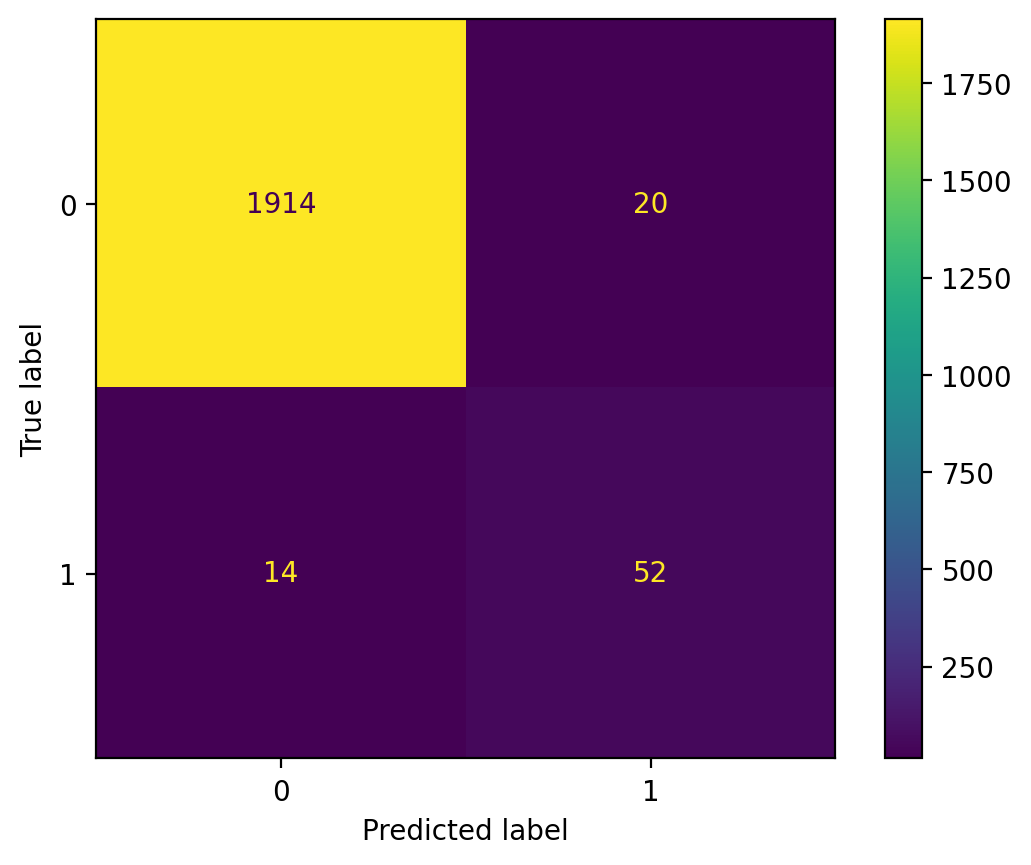

In [85]:
cm = confusion_matrix(y_dummy_test, y_pred_nn, labels=nn_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nn_model.classes_)
disp.plot()

In [86]:
print(classification_report(y_dummy_test, y_pred_nn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1934
           1       0.72      0.79      0.75        66

    accuracy                           0.98      2000
   macro avg       0.86      0.89      0.87      2000
weighted avg       0.98      0.98      0.98      2000



In [54]:
f1_nn = f1_score(y_dummy_test, y_pred_nn)
f1_nn

0.7536231884057971

### Logistic Regression

In [21]:
log_model = LogisticRegression(random_state=RANDOM_SEED)

log_model.fit(X_dummy_train, y_dummy_train)

y_pred_log = log_model.predict(X_dummy_test)

#### Accuracy and Classification Report - 0.970 accuracy, 0.344 f1-score

In [22]:
util.calculate_and_display_accuracy(log_model, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   0.9738
Model Test accuracy:                                       0.9695
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


(0.97375, 0.9695, 0.967, 0.967)

In [23]:
accuracy_log = accuracy_score(y_dummy_test, y_pred_log)

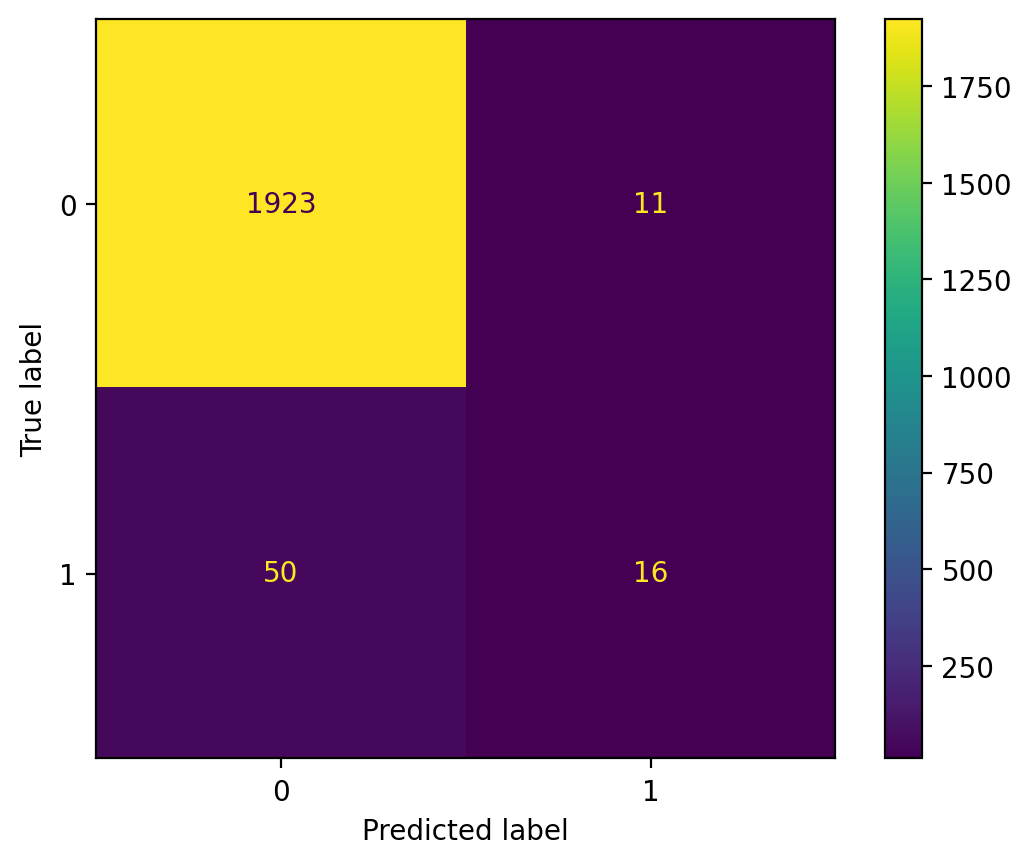

In [24]:
cm = confusion_matrix(y_map_test, y_pred_log, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
disp.plot()

In [25]:
print(classification_report(y_dummy_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1934
           1       0.59      0.24      0.34        66

    accuracy                           0.97      2000
   macro avg       0.78      0.62      0.66      2000
weighted avg       0.96      0.97      0.96      2000



In [53]:
f1_log = f1_score(y_dummy_test, y_pred_log)
f1_log

0.3440860215053763

### Decision Tree

In [27]:
# Create the classifier, fit it on the training data and make predictions on the test set
tree_model = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED)

tree_model.fit(X_map_train, y_map_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [29]:
# Make predictions for test data
y_pred = tree_model.predict(X_map_test) 
y_pred_flt = np.array(y_pred).flatten()
y_test_flt = np.array(y_map_test).flatten()
y_train_flt = np.array(y_map_train).flatten()
y_pred_tree = y_pred

#### Accuracy and Classification Report - 0.986 accuracy, 0.803 f1-score

In [30]:
util.calculate_and_display_accuracy(tree_model, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   1.0
Model Test accuracy:                                       0.986
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


(1.0, 0.986, 0.967, 0.967)

In [31]:
accuracy_tree = accuracy_score(y_dummy_test, y_pred_tree)

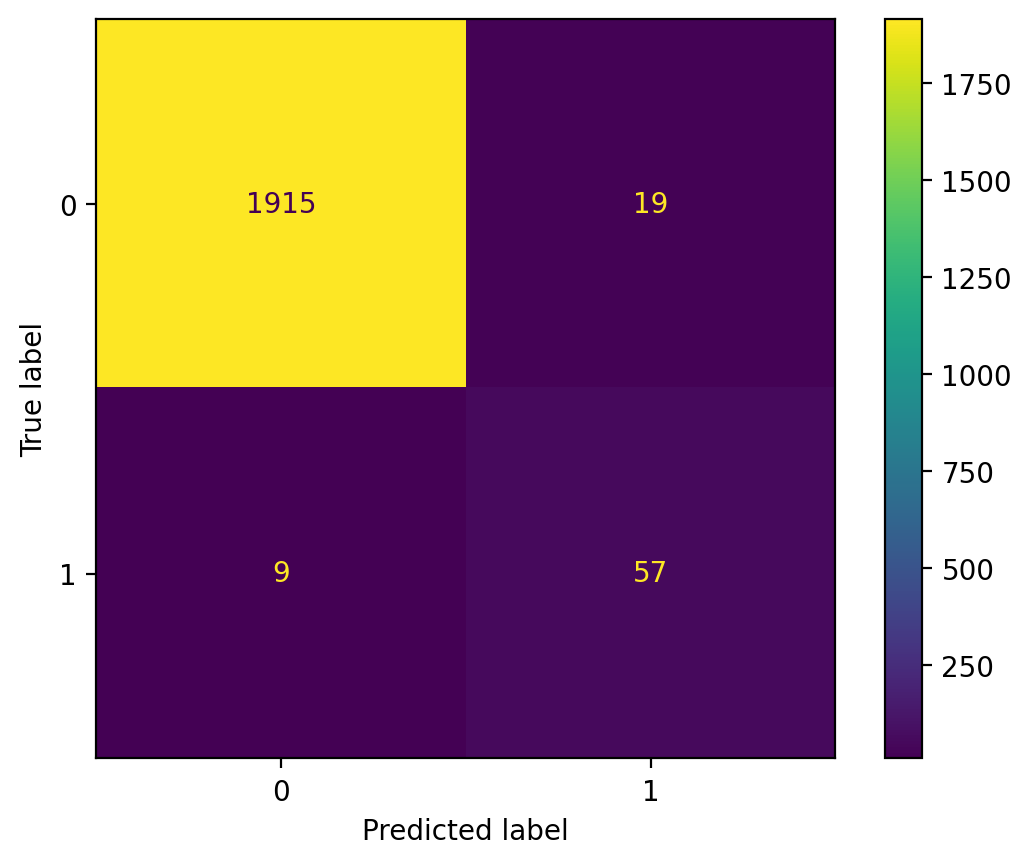

In [33]:
cm = confusion_matrix(y_map_test, y_pred_tree, labels=tree_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_model.classes_)
disp.plot()

In [34]:
print(classification_report(y_map_test, y_pred_tree))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1934
           1       0.75      0.86      0.80        66

    accuracy                           0.99      2000
   macro avg       0.87      0.93      0.90      2000
weighted avg       0.99      0.99      0.99      2000



In [52]:
f1_tree = f1_score(y_map_test, y_pred_tree)
f1_tree

0.8028169014084506

#### Other metrics

##### check predictive performance

In [36]:
# Calculate accuracy 
acc = accuracy_score(y_map_test,y_pred) * 100
print('Accuracy is : {0}'.format(acc))

# Check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_map_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is : {0}'.format(round(roc_auc, 2)))

# Create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test_flt, y_pred_flt, rownames=['True'], colnames=['Predicted'], margins=True)

Accuracy is : 98.6

AUC is : 0.93

Confusion Matrix
----------------


Predicted,0,1,All
True,,,
0,1915,19,1934
1,9,57,66
All,1924,76,2000


##### Building Decision tree

In [38]:
# Plot and show decision tree
plt.figure(figsize=(12,12), dpi=500)
tree.plot_tree(tree_model, 
               feature_names=X_map.columns.tolist(),
               class_names=np.unique(y_map).astype('str').tolist(),
               filled=True, rounded=True)
plt.show()

### Support Vector Machine

In [39]:
svm_model = SVC(random_state=RANDOM_SEED)

# Fit the model to the training data
svm_model.fit(X_dummy_train, y_dummy_train)

# Predict
y_pred_svm = svm_model.predict(X_dummy_test)

#### Accuracy and Classification Report - 0.978 accuracy, 0.516 f1-score

In [40]:
util.calculate_and_display_accuracy(svm_model, X_dummy_train, y_dummy_train, X_dummy_test, y_dummy_test)

Model Training accuracy:                                   0.981
Model Test accuracy:                                       0.9775
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


(0.981, 0.9775, 0.967, 0.967)

In [41]:
accuracy_svm = accuracy_score(y_dummy_test, y_pred_svm)

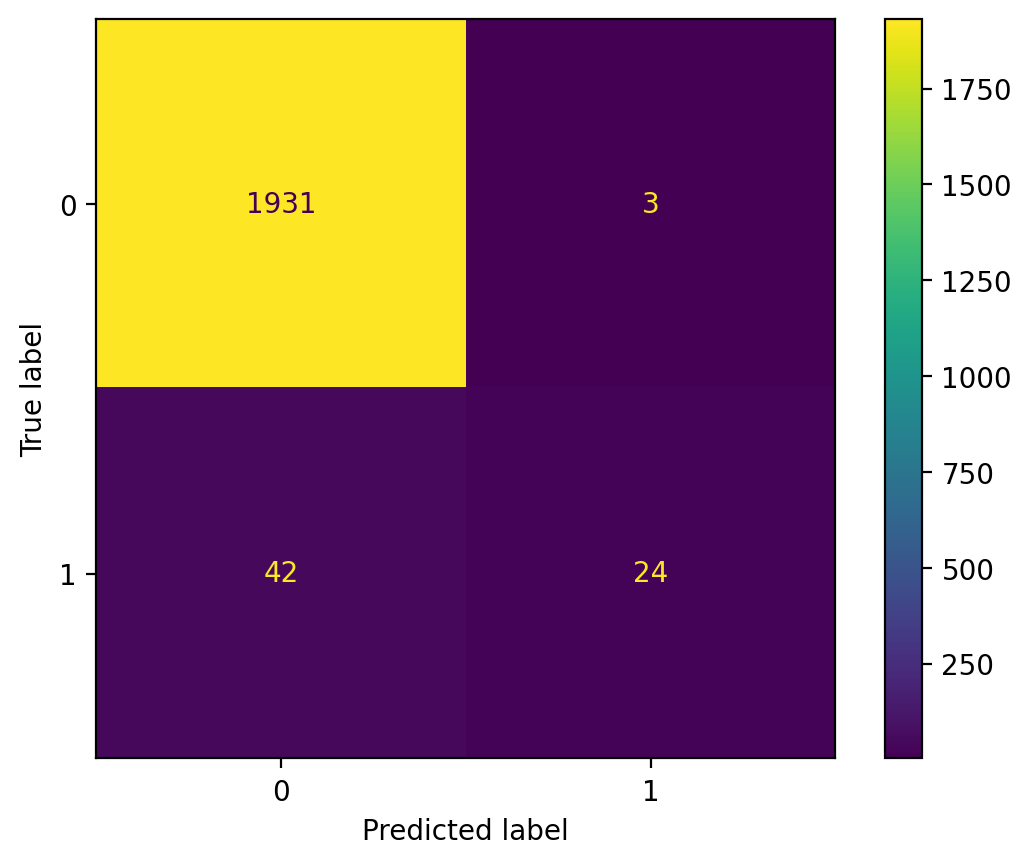

In [42]:
cm = confusion_matrix(y_dummy_test, y_pred_svm, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot()

In [43]:
print(classification_report(y_dummy_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1934
           1       0.89      0.36      0.52        66

    accuracy                           0.98      2000
   macro avg       0.93      0.68      0.75      2000
weighted avg       0.98      0.98      0.97      2000



In [44]:
f1_svm = f1_score(y_dummy_test, y_pred_svm)
f1_svm

0.5161290322580644

### Random Forest

In [55]:
#rf_model = RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1, max_depth=13, max_features=0.88, min_samples_leaf=5, n_estimators=115)
rf_model = RandomForestClassifier(random_state=RANDOM_SEED)
rf_model.fit(X_map_train, y_map_train)
y_pred_rf = rf_model.predict(X_map_test)

#### Accuracy and Classification Report - 0.993 accuracy, 0.882 f1-score

In [56]:
util.calculate_and_display_accuracy(rf_model, X_map_train, y_map_train, X_map_test, y_map_test)

Model Training accuracy:                                   1.0
Model Test accuracy:                                       0.9925
Baseline, Naive model (always guess 0) training accuracy:  0.967
Baseline, Naive model (always guess 0) test accuracy:      0.967


(1.0, 0.9925, 0.967, 0.967)

In [57]:
accuracy_rf = accuracy_score(y_dummy_test, y_pred_rf)

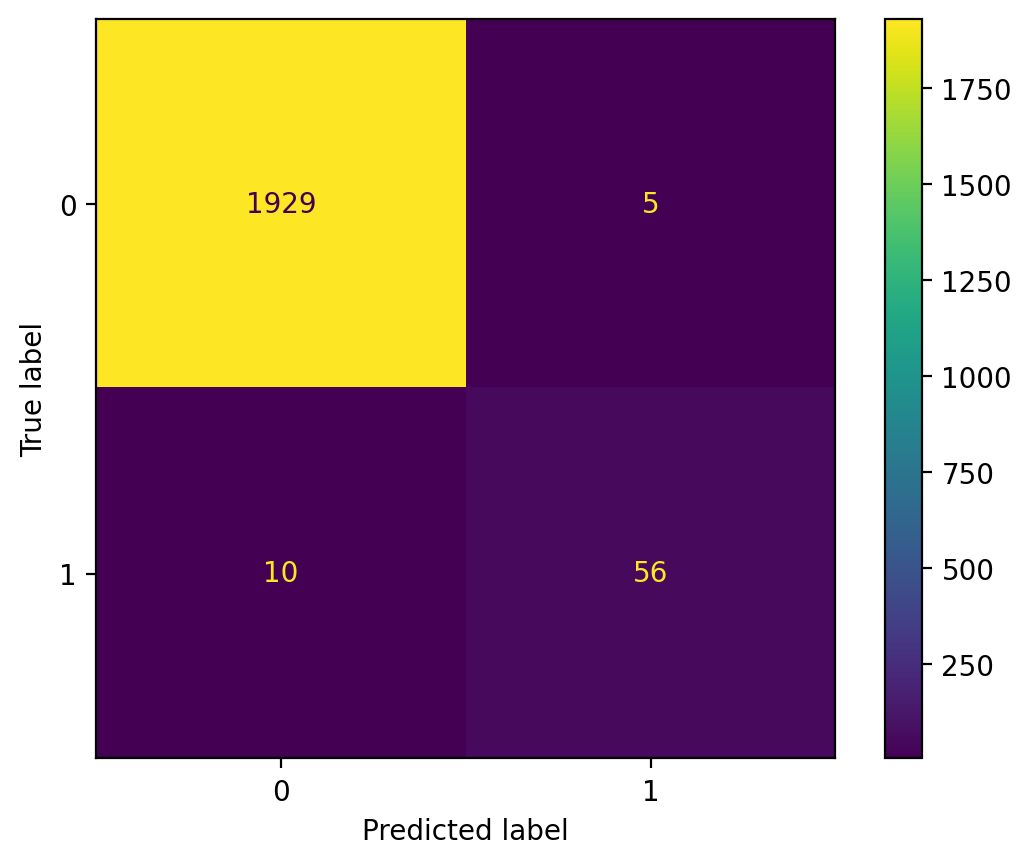

In [58]:
cm = confusion_matrix(y_map_test, y_pred_rf, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
#plt.savefig('random_forest_test_confusion_matrix.svg', format='svg', bbox_inches='tight')

In [59]:
print(classification_report(y_map_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1934
           1       0.92      0.85      0.88        66

    accuracy                           0.99      2000
   macro avg       0.96      0.92      0.94      2000
weighted avg       0.99      0.99      0.99      2000



In [60]:
f1_rf = f1_score(y_map_test, y_pred_rf)
f1_rf

0.8818897637795275

## Performance Graphs

In [85]:
# Function from Abdo and Ch3steR (from: stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot)
# Palette documentation (from: seaborn.pydata.org/generated/seaborn.color_palette.html)
custom_palette = 'blend:#046A38,#86BC25'

def colors_from_values(values, palette_name=custom_palette):
    # normalize the values to range [0, 1]
    normalized = (values - np.min(values)) / (np.max(values) - np.min(values))
    # convert to indices
    indices = np.round((1 - normalized) * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)
    
# set theme and context
sns.set_theme(style="whitegrid")
sns.set_context('poster', rc={'patch.linewidth': 0.6})

In [72]:
# save metrics into dataframes
accuracy_df = pd.DataFrame({'model': ['deep neural networks', 'logistic regression', 'decision tree', 'support vector machine', 'random forest', 'baseline model'],
                            'accuracy': [accuracy_nn, accuracy_log, accuracy_tree, accuracy_svm, accuracy_rf, accuracy_baseline]}).sort_values(by=['accuracy'], ascending=False)
f1_df = pd.DataFrame({'model': ['deep neural networks', 'logistic regression', 'decision tree', 'support vector machine', 'random forest'],
                      'f1_score': [f1_nn, f1_log, f1_tree, f1_svm, f1_rf]}).sort_values(by=['f1_score'], ascending=False)

### Accuracy

C:\Users\hzuo\AppData\Local\Temp\ipykernel_13884\3996483216.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



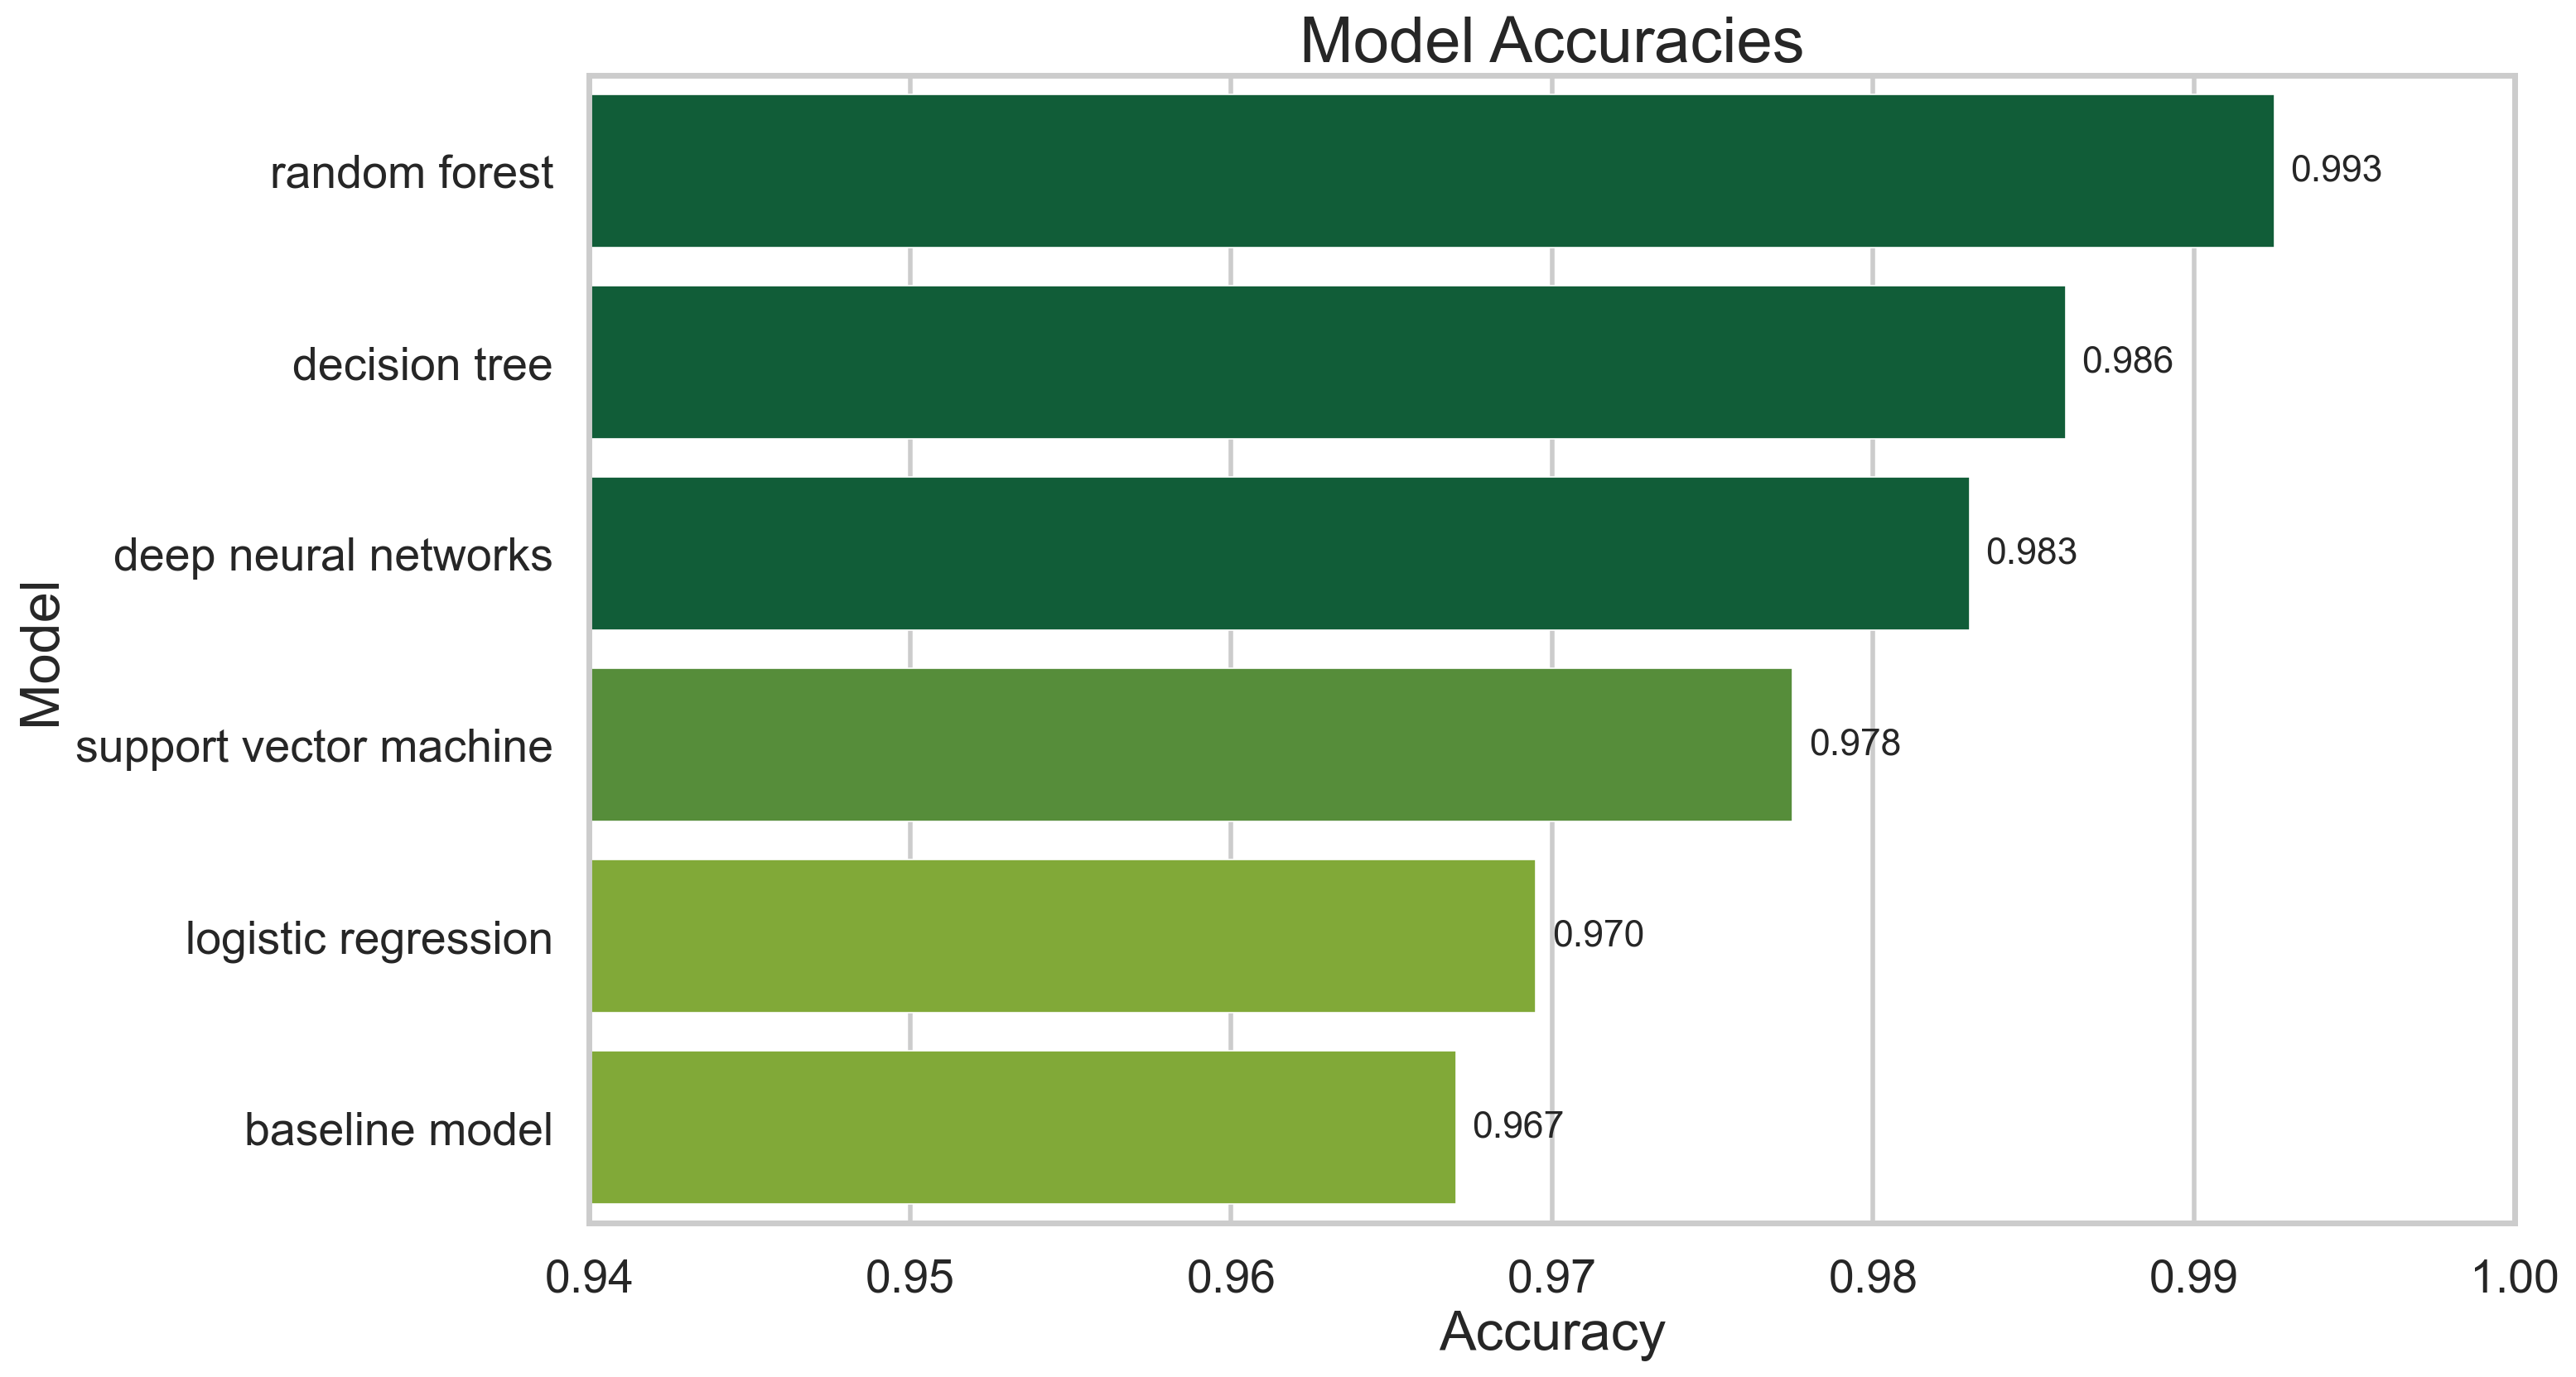

In [108]:
colors = ['#046A38' if acc > 0.98 else palette_color for acc, palette_color in zip(accuracy_df['accuracy'], colors_from_values(accuracy_df['accuracy']))]

plt.figure(figsize=(15,9))
ax = sns.barplot(data=accuracy_df, x='accuracy', y='model', orient='h', palette=colors)
for container in ax.containers:
    ax.bar_label(container, padding=7, fontsize=16, fmt='%.3f')
plt.title('Model Accuracies', fontsize=28)
plt.xlabel('Accuracy', fontsize=24)
plt.ylabel('Model', fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlim(0.94, 1)
plt.savefig('images/model_accuracy.svg', format='svg', bbox_inches='tight')

### F1-score

C:\Users\hzuo\AppData\Local\Temp\ipykernel_13884\1292604893.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



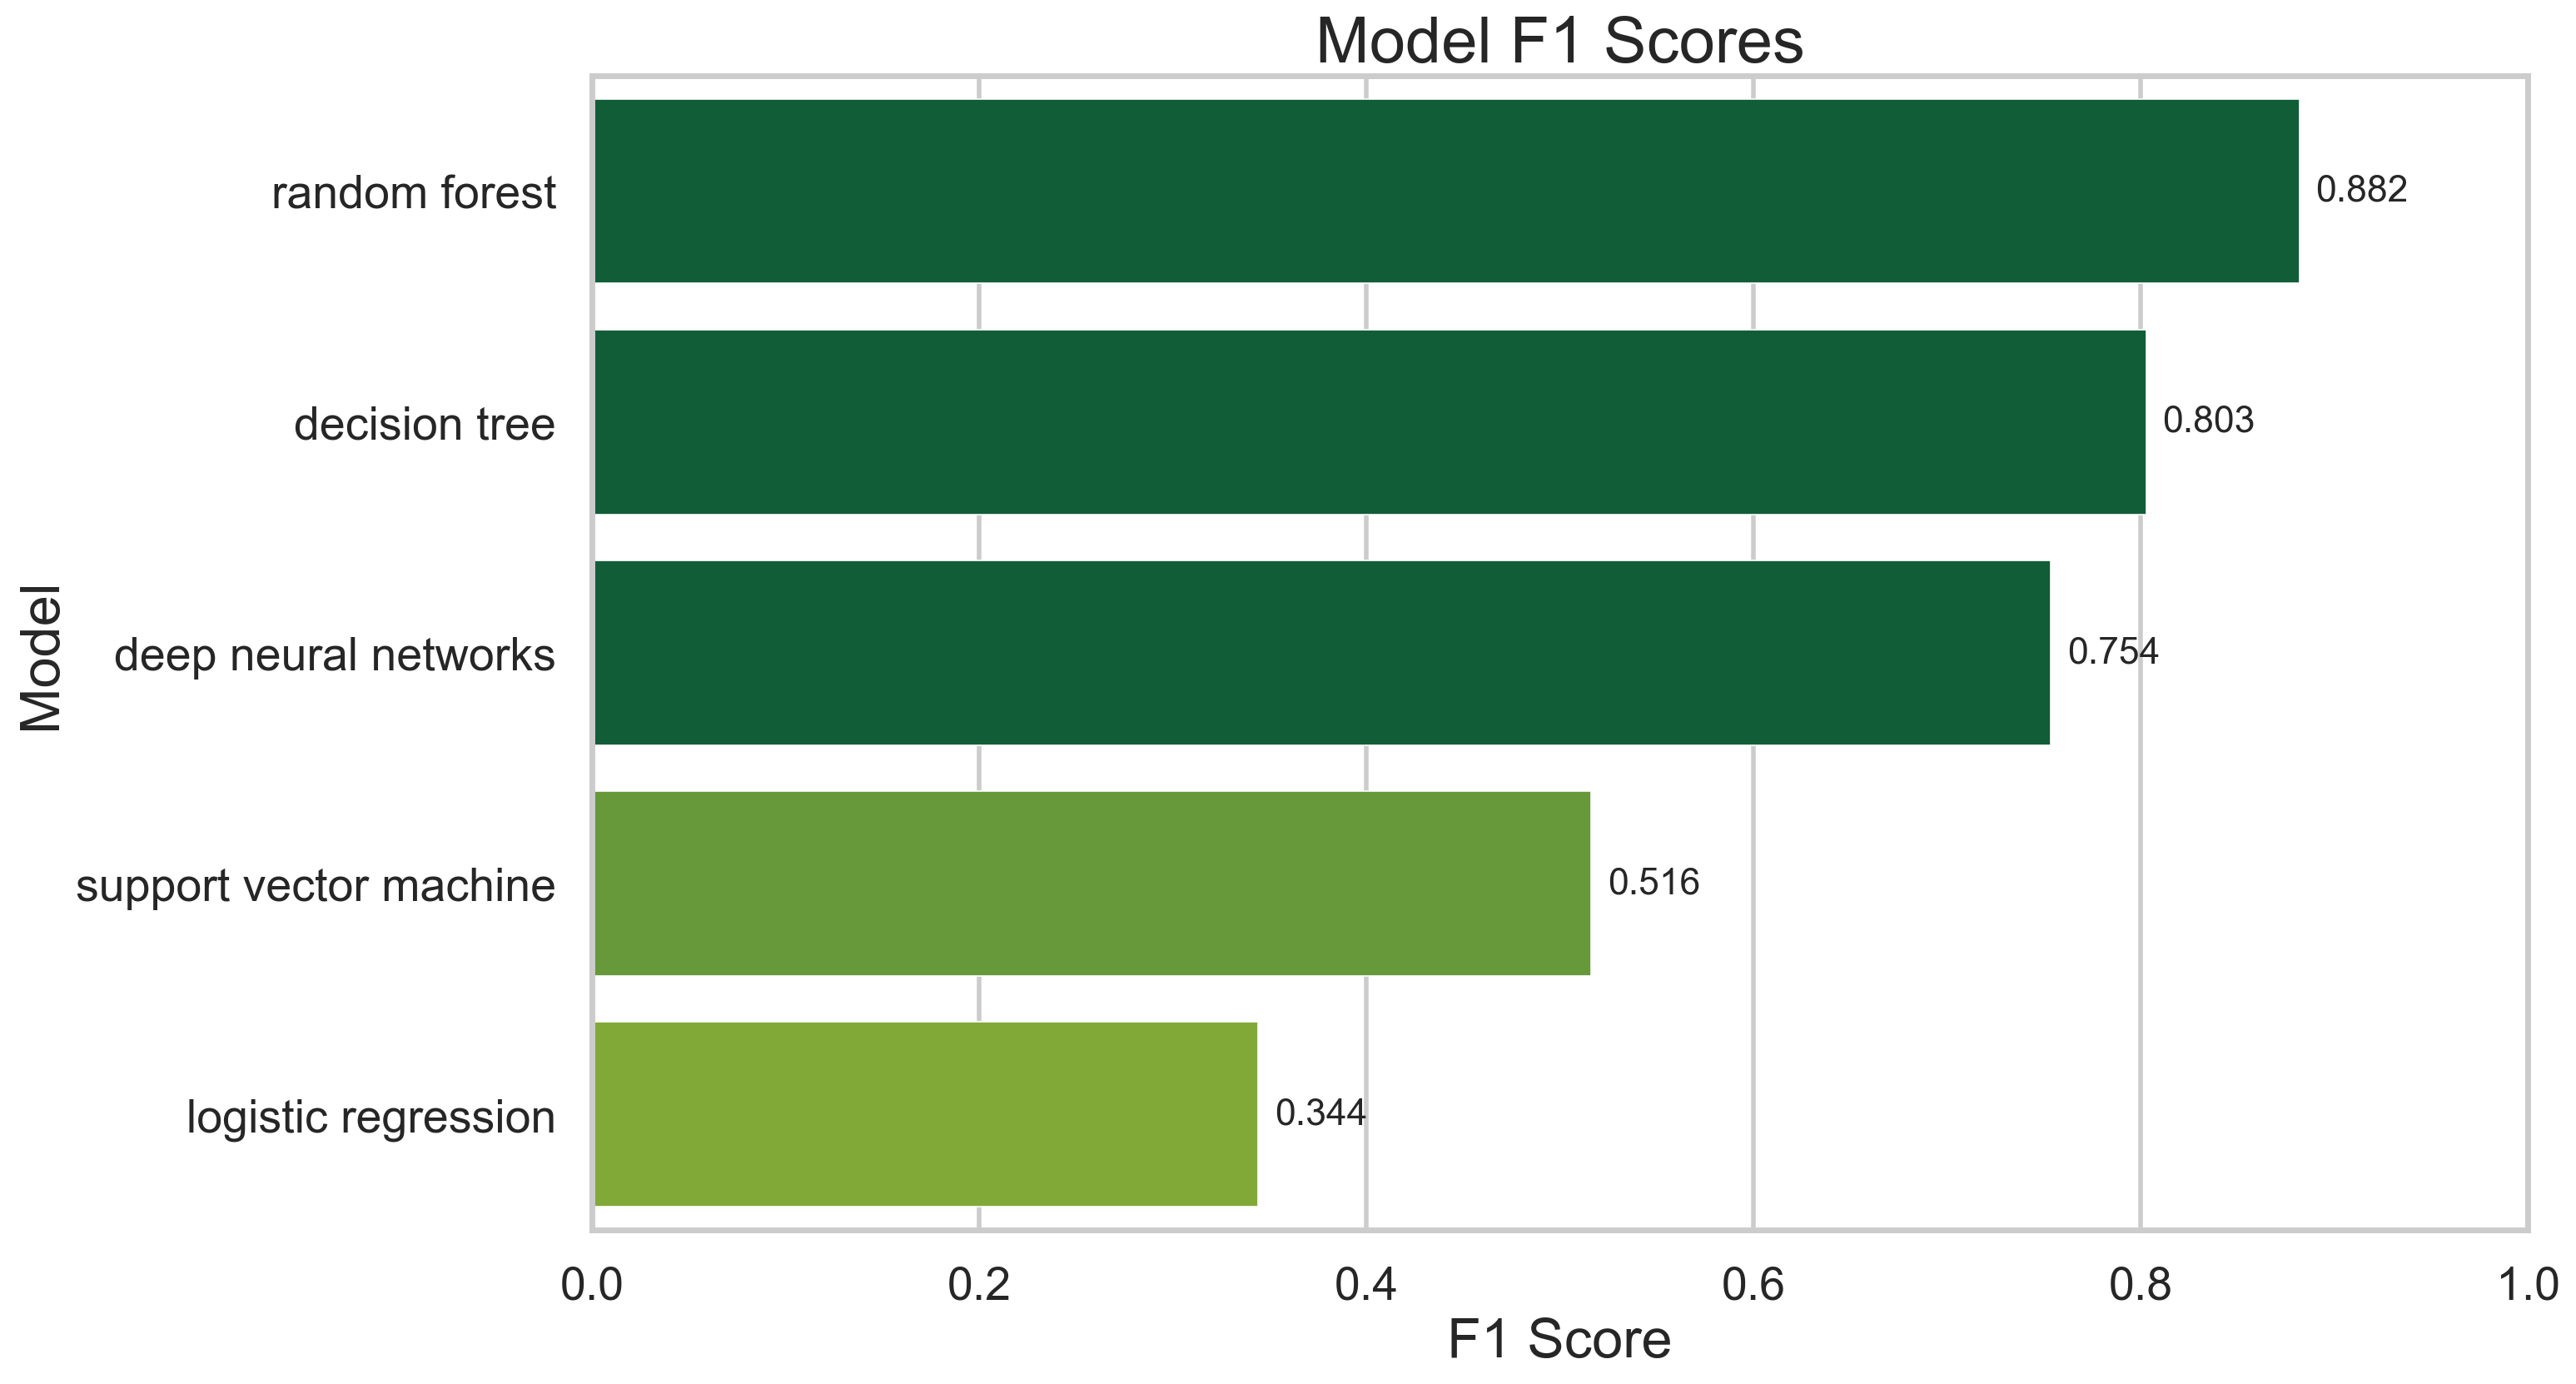

In [115]:
colors = ['#046A38' if f1 > 0.7 else palette_color for f1, palette_color in zip(f1_df['f1_score'], colors_from_values(f1_df['f1_score']))]

plt.figure(figsize=(15,9))
ax = sns.barplot(data=f1_df, x='f1_score', y='model', orient='h', palette=colors)
for container in ax.containers:
    ax.bar_label(container, padding=7, fontsize=16, fmt='%.3f')
plt.title('Model F1 Scores', fontsize=28)
plt.xlabel('F1 Score', fontsize=24)
plt.ylabel('Model', fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlim(0, 1)
plt.savefig('images/model_f1_scores.svg', format='svg', bbox_inches='tight')